# **Product Title Classification Project**

**Objective:**  
I want to build a machine learning model that can automatically classify product titles into their correct categories. This will help e-commerce platforms organize products and improve search results.

**Dataset:**  
I am using a dataset of product listings with features like product title, merchant info, category labels, and other metadata.

**My Tasks:**  
- Clean and preprocess product titles.  
- Engineer simple features like title length, word count, presence of digits, or brand keywords.  
- Train and compare multiple classifiers: **Logistic Regression**, **Linear SVC**, **Random Forest**, and **Multinomial Naive Bayes**.  
- Evaluate models and select the best performing one.  
- Save the final model for future predictions.

**Author:**  
**Arnel Kovacevic**

**Date:**  
**December 2025**

**-----------------------------------**


In [20]:

import pandas as pd

# load dataset (adjust path if needed)
df = pd.read_csv("../data/products.csv")

# Quick look
print("Shape:", df.shape)
display(df.head())

Shape: (35311, 8)


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


## Checking for missing values

In [21]:

# Standardize column names (strip spaces)
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
df.rename(columns={
    "product_id": "product_id",
    "product_title": "product_title",
    "merchant_id": "merchant_id",
    "category_label": "category_label",
    "_product_code": "product_code",
    "number_of_views": "number_of_views",
    "merchant_rating": "merchant_rating",
    "listing_date": "listing_date"
}, inplace=True)

# 1) Count missing
print("Missing values per column:")
print(df.isna().sum())

Missing values per column:
product_id           0
product_title      172
merchant_id          0
category_label      44
product_code        95
number_of_views     14
merchant_rating    170
listing_date        59
dtype: int64


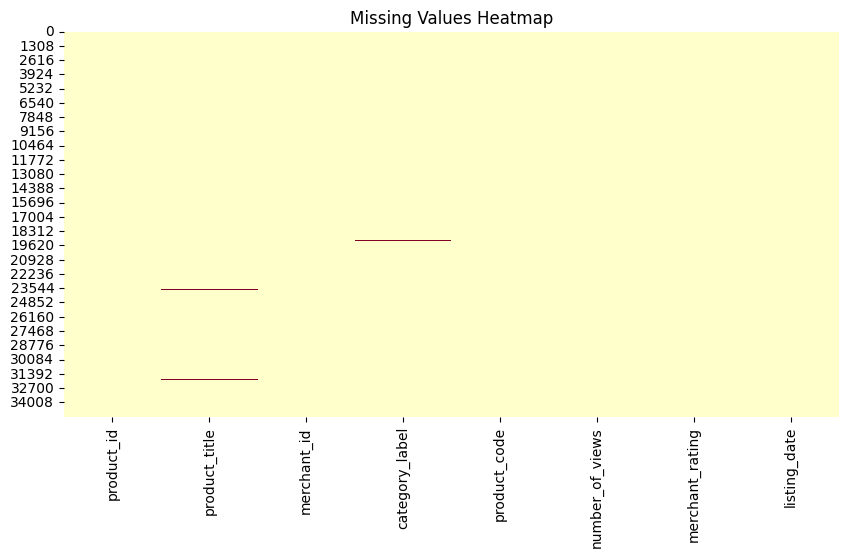

In [22]:
# Visualize missing data with seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap")
plt.show()

## Cleaned raw dataset
- Removed rows without product_title or category_label
- Parsed listing_date with error coercion
- Converted numeric fields and filled missing values with medians
- Normalized product titles (lowercase, stripped, NaN→“”)
- Removed invalid merchant ratings
- Dropped duplicate (product_title, merchant_id) pairs

In [23]:
# 2) Drop rows with no title or no label (we need both to train)
df = df.dropna(subset=["product_title", "category_label"]).reset_index(drop=True)
print("After dropping rows without title/label:", df.shape)

# 3) Parse listing_date to datetime (some rows may be bad)
df['listing_date'] = pd.to_datetime(df['listing_date'], errors='coerce')
print("Listing date parsed; nulls:", df['listing_date'].isna().sum())

# 4) Fill numeric NaNs with medians 
df['merchant_rating'] = pd.to_numeric(df['merchant_rating'], errors='coerce')
df['number_of_views'] = pd.to_numeric(df['number_of_views'], errors='coerce')

df['merchant_rating'] = df['merchant_rating'].fillna(df['merchant_rating'].median())
df['number_of_views'] = df['number_of_views'].fillna(df['number_of_views'].median())


# 5) Clean product_title text: lowercase, strip spaces
df['product_title'] = df['product_title'].astype(str).str.lower().str.strip()
df['product_title'] = df['product_title'].fillna('').astype(str)


# 6) Remove obvious bad merchant_rating values (like negative or >5)
df.loc[df['merchant_rating'] > 5, 'merchant_rating'] = df['merchant_rating'].median()
df.loc[df['merchant_rating'] < 0, 'merchant_rating'] = df['merchant_rating'].median()

# 7) Optional: drop duplicates by product_title (keeps first)
before = df.shape[0]
df = df.drop_duplicates(subset=['product_title', 'merchant_id']).reset_index(drop=True)
after = df.shape[0]
print(f"Dropped {before-after} duplicates")

# Quick checks
print("Categories count:", df['category_label'].nunique())
print(df['category_label'].value_counts().head(20))


After dropping rows without title/label: (35096, 8)
Listing date parsed; nulls: 58
Dropped 1246 duplicates
Categories count: 13
category_label
Fridge Freezers     5255
Mobile Phones       3980
Washing Machines    3724
TVs                 3490
CPUs                3465
Fridges             3348
Dishwashers         3286
Digital Cameras     2687
Microwaves          2245
Freezers            2119
fridge               119
CPU                   77
Mobile Phone          55
Name: count, dtype: int64


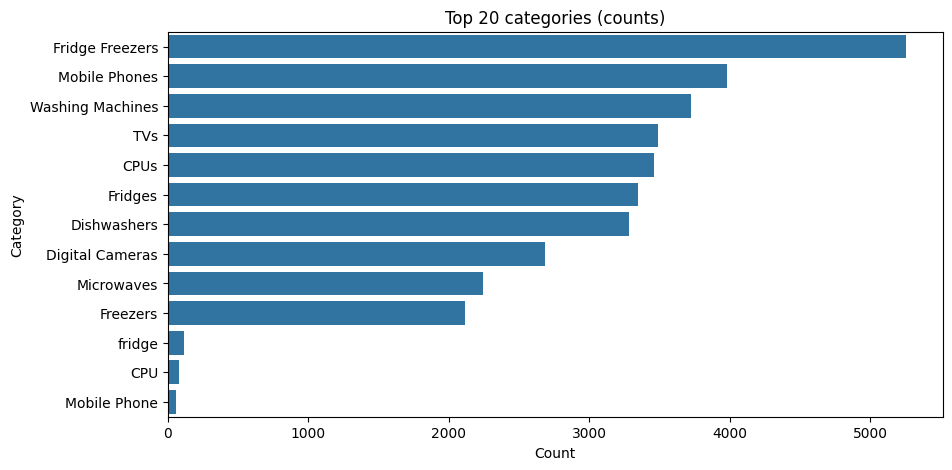

In [24]:
# Plot class distribution (top categories)
plt.figure(figsize=(10,5))
top_cats = df['category_label'].value_counts().nlargest(20)
sns.barplot(y=top_cats.index, x=top_cats.values)
plt.title("Top 20 categories (counts)")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()

# **Group Small Categories into 'Other'**

**Why:** Small categories have few samples and can hurt model training.  
**How:** I group categories with fewer than 50 examples into a new category **'Other'**.  


In [27]:
# Group small classes into 'Other' 
min_count = 50  
cat_counts = df['category_label'].value_counts()
small_cats = cat_counts[cat_counts < min_count].index.tolist()

print("Number of small categories:", len(small_cats))
df['category_label_reduced'] = df['category_label'].apply(lambda x: x if x not in small_cats else 'Other')

print(df['category_label_reduced'].value_counts().head(30))

Number of small categories: 0
category_label_reduced
Fridge Freezers     5255
Mobile Phones       3980
Washing Machines    3724
TVs                 3490
CPUs                3465
Fridges             3348
Dishwashers         3286
Digital Cameras     2687
Microwaves          2245
Freezers            2119
fridge               119
CPU                   77
Mobile Phone          55
Name: count, dtype: int64


# **Basic Feature Engineering**

**Goal:** Extract simple features from product titles to help the model.  

**Features:**
- **title_len:** number of characters  
- **title_word_count:** number of words  
- **has_digit:** 1 if title contains numbers  
- **has_plus:** 1 if title contains '+' (e.g., "iPhone 8 Plus")  
- **num_uppercase_words:** count of fully uppercase words  
- **brand_flag:** 1 if first word matches known brands (`apple`, `samsung`, etc.)  

**Result:** Creates structured features from raw text for better model learning.  


In [15]:
# Basic engineered features
df['title_len'] = df['product_title'].str.len()
df['title_word_count'] = df['product_title'].str.split().str.len()
df['has_digit'] = df['product_title'].str.contains(r'\d').astype(int)
df['has_plus'] = df['product_title'].str.contains(r'\+').astype(int)   # e.g. "iphone 8 plus"
df['num_uppercase_words'] = df['product_title'].apply(lambda t: sum(1 for w in t.split() if w.isupper()))

# Example: brand detection (simple heuristic: first token)
df['first_token'] = df['product_title'].str.split().str[0]
# you can create a small list of known brands (optional)
brands = ['apple','samsung','sony','bosch','kenwood','smeg','olympus']
df['brand_flag'] = df['first_token'].isin(brands).astype(int)

df[['product_title','title_len','title_word_count','has_digit','brand_flag']].head()


,product_title,title_len,title_word_count,has_digit,brand_flag
0,apple iphone 8 plus 64gb silver,31,6,1,1
1,apple iphone 8 plus 64 gb spacegrau,35,7,1,1
2,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,70,13,1,1
3,apple iphone 8 plus 64gb space grey,35,7,1,1
4,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,54,11,1,1


## ---------------------------------------------------------

## Dataset is now fully cleaned and enriched for model training.

## ---------------------------------------------------------


## Training and Comparing Multiple Machine Learning Models

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import joblib

# ---------------------------------------------------------
# 1) DATA SPLIT
# ---------------------------------------------------------
X = df[['product_title', 'title_len', 'title_word_count', 'has_digit',
        'has_plus', 'num_uppercase_words', 'brand_flag']]
y = df['category_label_reduced']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------------------------------------------------------
# 2) Preprocessors
# ---------------------------------------------------------

# StandardScaler works well for most models
preprocessor_std = ColumnTransformer(
    transformers=[
        ("title", TfidfVectorizer(ngram_range=(1,2), min_df=3), "product_title"),
        ("nums", StandardScaler(), 
         ["title_len","title_word_count","has_digit","has_plus",
          "num_uppercase_words","brand_flag"])
    ]
)

# Naive Bayes requires strictly positive values → MinMaxScaler (0–1)
preprocessor_nb = ColumnTransformer(
    transformers=[
        ("title", TfidfVectorizer(ngram_range=(1,2), min_df=3), "product_title"),
        ("nums", MinMaxScaler(), 
         ["title_len","title_word_count","has_digit","has_plus",
          "num_uppercase_words","brand_flag"])
    ]
)

# ---------------------------------------------------------
# 3) Models to test
# ---------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVC": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "Multinomial NB": MultinomialNB()
}

# ---------------------------------------------------------
# 4) Training & evaluating all models
# ---------------------------------------------------------
results = {}

for name, model in models.items():
    print("\n==============================")
    print("🔍 MODEL:", name)
    print("==============================")
    
    # Select the correct preprocessor (NB → MinMaxScaler)
    if name == "Multinomial NB":
        pipeline = Pipeline([
            ("preprocessing", preprocessor_nb),
            ("classifier", model)
        ])
    else:
        pipeline = Pipeline([
            ("preprocessing", preprocessor_std),
            ("classifier", model)
        ])
    
    # Train
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Score
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    results[name] = (acc, pipeline)

# ---------------------------------------------------------
# 5) Selecting the best model
# ---------------------------------------------------------
best_model_name = max(results, key=lambda n: results[n][0])
best_acc, best_pipeline = results[best_model_name]

print("\n\n==============================")
print("🏆 BEST MODEL:", best_model_name)
print(f"🏆 Accuracy: {best_acc:.4f}")
print("==============================")

# ---------------------------------------------------------
# 6) Saving the final model
# ---------------------------------------------------------
joblib.dump(best_pipeline, "model_beta.joblib")
print("\n📦 Model saved as model_beta.joblib")



🔍 MODEL: Logistic Regression
Accuracy: 0.9470
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        15
            CPUs       0.98      1.00      0.99       693
 Digital Cameras       0.99      0.99      0.99       537
     Dishwashers       0.89      0.96      0.93       657
        Freezers       0.98      0.90      0.94       424
 Fridge Freezers       0.94      0.92      0.93      1051
         Fridges       0.87      0.89      0.88       670
      Microwaves       1.00      0.94      0.97       449
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.96      0.99      0.98       796
             TVs       0.97      0.98      0.97       698
Washing Machines       0.93      0.95      0.94       745
          fridge       0.00      0.00      0.00        24

        accuracy                           0.95      6770
       macro avg       0.73      0.73      0.73      6770
    weighted avg       

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Accuracy: 0.9518
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        15
            CPUs       0.98      1.00      0.99       693
 Digital Cameras       1.00      0.99      0.99       537
     Dishwashers       0.91      0.96      0.94       657
        Freezers       0.93      0.92      0.92       424
 Fridge Freezers       0.93      0.94      0.94      1051
         Fridges       0.89      0.89      0.89       670
      Microwaves       0.99      0.94      0.97       449
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.97      0.99      0.98       796
             TVs       0.98      0.99      0.99       698
Washing Machines       0.97      0.95      0.96       745
          fridge       0.00      0.00      0.00        24

        accuracy                           0.95      6770
       macro avg       0.73      0.74      0.74      6770
    weighted avg       0.95      0.95      0.95      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

Accuracy: 0.9516
                  precision    recall  f1-score   support

             CPU       0.00      0.00      0.00        15
            CPUs       0.98      0.99      0.98       693
 Digital Cameras       0.99      0.98      0.99       537
     Dishwashers       0.95      0.97      0.96       657
        Freezers       0.96      0.92      0.94       424
 Fridge Freezers       0.92      0.94      0.93      1051
         Fridges       0.89      0.88      0.89       670
      Microwaves       0.96      0.96      0.96       449
    Mobile Phone       0.00      0.00      0.00        11
   Mobile Phones       0.98      0.99      0.98       796
             TVs       0.98      0.99      0.98       698
Washing Machines       0.96      0.96      0.96       745
          fridge       0.00      0.00      0.00        24

        accuracy                           0.95      6770
       macro avg       0.74      0.74      0.74      6770
    weighted avg       0.95      0.95      0.95      

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beha

# **Model Evaluation & Beta Ready**

**Models tested:**
- **Logistic Regression** – Accuracy: 0.9470  
- **Linear SVC** – Accuracy: 0.9518  
- **Random Forest** – Accuracy: 0.9516  
- **Multinomial NB** – Accuracy: 0.9518  

**Observation:**  
All models perform well (>95% accuracy) on main categories. Some very small categories have zero predictions.

**Beta Testing:**  
- The final model for beta testing is saved as **`model_beta.joblib`**  
- Ready to load and test interactively on new product titles.  
